## Processed Feature set

In [ ]:
import pandas as pd
import numpy as np

# Function to load and preprocess the Titanic data
def load_and_preprocess_titanic_data():
    def _bin_age(age_series):
        bins = [-np.inf, 10, 40, np.inf]
        labels = ["Child", "Adult", "Elderly"]
        return pd.cut(age_series, bins=bins, labels=labels, right=True).astype(str).replace("nan", "Unknown")

    def _extract_title(name_series):
        titles = name_series.str.extract(" ([A-Za-z]+)\.", expand=False)
        rare_titles = {
            "Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"
        }
        titles = titles.replace(list(rare_titles), "Rare")
        titles = titles.replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
        return titles

    def _create_features(df):
        df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
        df["Age"] = _bin_age(df["Age"])
        df["Cabin"] = df["Cabin"].str[0].fillna("Unknown")
        df["Title"] = _extract_title(df["Name"])
        df.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
        return df

    df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
    print("Original features:")
    print(df.columns.tolist())
    processed_df = df.dropna(subset=["Embarked", "Fare"]).copy()
    processed_df = _create_features(processed_df)
    print("Processed features:")
    print(processed_df.columns.tolist())
    return processed_df

# Loading and preprocessing the data
processed_df = load_and_preprocess_titanic_data()


Original features:
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Processed features:
['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']


## Vertical Split after one-hot encoding

Client 1 Final Features: ['Pclass', 'Fare', 'Age_Adult', 'Age_Unknown', 'Cabin_C', 'Cabin_F', 'Cabin_Unknown', 'Embarked_S', 'Title_Mr']
Client 2 Final Features: ['SibSp', 'Sex_female', 'Age_Child', 'Cabin_A', 'Cabin_D', 'Cabin_G', 'Embarked_C', 'Title_Master', 'Title_Mrs']
Client 3 Final Features: ['Parch', 'Sex_male', 'Age_Elderly', 'Cabin_B', 'Cabin_E', 'Cabin_T', 'Embarked_Q', 'Title_Miss', 'Title_Rare']
Client 1 Final Features: ['Pclass', 'Fare', 'Age_Adult', 'Age_Unknown', 'Cabin_C', 'Cabin_F', 'Cabin_Unknown', 'Embarked_S', 'Title_Mr']
Client 2 Final Features: ['SibSp', 'Sex_female', 'Age_Child', 'Cabin_A', 'Cabin_D', 'Cabin_G', 'Embarked_C', 'Title_Master', 'Title_Mrs']
Client 3 Final Features: ['Parch', 'Sex_male', 'Age_Elderly', 'Cabin_B', 'Cabin_E', 'Cabin_T', 'Embarked_Q', 'Title_Miss', 'Title_Rare']
Input sizes: [9, 9, 9]
Federated Round 1/1000
Test set: Average loss: 0.7218, Accuracy: 63/178 (35%)
Federated Round 2/1000
Test set: Average loss: 0.7134, Accuracy: 69/178 (39

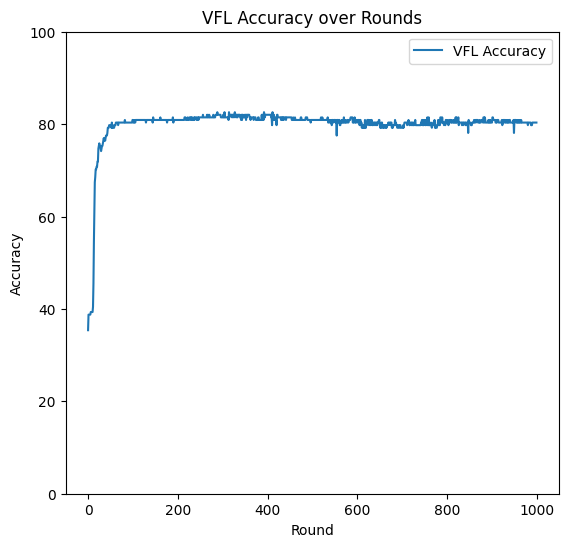

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import random

seed = 55
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def load_titanic_data():
    def _bin_age(age_series):
        bins = [-np.inf, 10, 40, np.inf]
        labels = ["Child", "Adult", "Elderly"]
        return pd.cut(age_series, bins=bins, labels=labels, right=True).astype(str).replace("nan", "Unknown")

    def _extract_title(name_series):
        titles = name_series.str.extract(" ([A-Za-z]+)\.", expand=False)
        rare_titles = {
            "Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"
        }
        titles = titles.replace(list(rare_titles), "Rare")
        titles = titles.replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
        return titles

    def _create_features(df):
        df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
        df["Age"] = _bin_age(df["Age"])
        df["Cabin"] = df["Cabin"].str[0].fillna("Unknown")
        df["Title"] = _extract_title(df["Name"])
        df.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
        return df

    def vertical_partition_rotating(df, num_participants):
        partitions = [[] for _ in range(num_participants)]
        num_features = df.shape[1]

        #  Round-Robin Vertical distribution of features after one-hot encoding
        for i, feature in enumerate(df.columns):
            participant = i % num_participants
            partitions[participant].append(feature)

        # Final feature set for each client after one-hot encoding
        for i, partition in enumerate(partitions):
            print(f"Client {i + 1} Final Features: {partition}")

        partitioned_dfs = [df[features] for features in partitions]
        return partitioned_dfs

    def get_partitions_and_label():
        df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
        processed_df = df.dropna(subset=["Embarked", "Fare"]).copy()
        processed_df = _create_features(processed_df)
        processed_df = pd.get_dummies(processed_df)  # One-hot encode the entire dataset before splitting
        labels = processed_df["Survived"].values

        # Train and test data split
        train_df, test_df, y_train, y_test = train_test_split(processed_df, labels, test_size=0.2, random_state=42)

        # vertical_partitioning_rotating function call
        train_partitions = vertical_partition_rotating(train_df.drop(columns=["Survived"]), 3)
        test_partitions = vertical_partition_rotating(test_df.drop(columns=["Survived"]), 3)

        # We need to ensuring each participant has access to labels
        for i in range(len(train_partitions)):
            train_partitions[i]['Survived'] = y_train

        for i in range(len(test_partitions)):
            test_partitions[i]['Survived'] = y_test

        return train_partitions, test_partitions, y_train, y_test

    # Partitions and Labels
    train_partitions, test_partitions, y_train, y_test = get_partitions_and_label()

    # Partitions to PyTorch datasets conversions
    def create_tensor_datasets(partitions):
        tensor_partitions = []
        for partition in partitions:
            partition = partition.apply(pd.to_numeric, errors='coerce')
            partition = partition.fillna(0)

            for col in partition.select_dtypes(include=['bool']).columns:
                partition[col] = partition[col].astype(int)

            features = partition.drop(columns=["Survived"]).values
            labels = partition["Survived"].values.astype(np.int64)

            tensor_partition = TensorDataset(torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.long))
            tensor_partitions.append(tensor_partition)
        return tensor_partitions

    train_tensor_partitions = create_tensor_datasets(train_partitions)
    test_tensor_partitions = create_tensor_datasets(test_partitions)

    return train_tensor_partitions, test_tensor_partitions, train_partitions, y_train, y_test

# Global Model definition
class GlobalModel(nn.Module):
    def __init__(self, input_sizes, hidden_sizes, output_size):
        super(GlobalModel, self).__init__()
        self.segments = nn.ModuleList()
        for input_size, hidden_size in zip(input_sizes, hidden_sizes):
            layers = [nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, output_size)]
            self.segments.append(nn.Sequential(*layers))

    def forward(self, x, active_segments):
        segment_outputs = []
        start_index = 0
        for i, segment in enumerate(self.segments):
            end_index = start_index + input_sizes[i]
            if i in active_segments:
                segment_input = x[:, start_index:end_index] # We extract the segment of the input corresponding to the active participant's features only
                segment_output = segment(segment_input)
                segment_outputs.append(segment_output)
            else:
                segment_outputs.append(torch.zeros(x.size(0), output_size, device=x.device)) # Non-active segments are appended with zero
            start_index = end_index
        combined_output = torch.mean(torch.stack(segment_outputs), dim=0)
        return combined_output

# Dataset
train_tensor_partitions, test_tensor_partitions, feature_partitions, y_train, y_test = load_titanic_data()

# Input sizes after one-hot encoding
input_sizes = [partition.shape[1] - 1 for partition in feature_partitions]  # minus 1 for 'Survived' column
print("Input sizes:", input_sizes)
hidden_sizes = [10] * 3
output_size = 2 # survive or dead?

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = [GlobalModel(input_sizes, hidden_sizes, output_size).to(device) for _ in range(3)]
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

# Class weights due to imbalance class distribution
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Training function
def train(model, device, train_loader, optimizer, epoch, input_sizes, participant_id):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        # Zero-padding non-responsible features
        padded_data = torch.zeros(data.size(0), sum(input_sizes)).to(device)
        start_index = sum(input_sizes[:participant_id])
        end_index = start_index + input_sizes[participant_id]
        padded_data[:, start_index:end_index] = data
        optimizer.zero_grad()
        output = model(padded_data, active_segments=[participant_id])
        loss = nn.CrossEntropyLoss(weight=class_weights)(output, target)
        loss.backward()
        optimizer.step()
        #if batch_idx % 10 == 0:
            #print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Selective gradient exchange function
def selective_exchange_gradients(models, input_sizes, hidden_sizes):
    num_models = len(models)
    param_indices = [0]
    cumulative_index = 0
    for i in range(len(hidden_sizes)):
        cumulative_index += (input_sizes[i] * hidden_sizes[i]) + hidden_sizes[i]
        param_indices.append(cumulative_index)

    for seg in range(len(hidden_sizes)):
        start = param_indices[seg]
        end = param_indices[seg + 1]
        for param_idx in range(start, end):
            grads = []
            for model in models:
                model_params = list(model.parameters())
                if param_idx < len(model_params) and model_params[param_idx].grad is not None:
                    grads.append(model_params[param_idx].grad)
            if grads:
                avg_grad = torch.stack(grads).mean(dim=0)
                for model in models:
                    model_params = list(model.parameters())
                    if param_idx < len(model_params):
                        model_params[param_idx].grad = avg_grad.clone()





# Model Training
federated_rounds = 1000  # To match with their setup
epochs_per_round = 1

# Lists to store accuracy after each round
vfl_accuracies = []

def evaluate(models, device, test_loaders):
    with torch.no_grad():
        test_loss = 0
        correct = 0
        all_preds = []
        all_targets = []

        for batch_data in zip(*test_loaders):
            data_list = []
            target_list = []
            for participant_id, (data, target) in enumerate(batch_data):
                data_list.append(data)
                target_list.append(target)

            target = target_list[0].to(device)
            for t in target_list:
                assert torch.equal(t, target), "Targets are not consistent across participants"

            data_combined = torch.cat(data_list, dim=1).to(device)


            #print("data_combined size:", data_combined.size())
            padded_data = torch.zeros(data_combined.size(0), sum(input_sizes)).to(device)
            #print("padded_data size before padding:", padded_data.size())

            start_index = 0
            for participant_id in range(len(input_sizes)):
                end_index = start_index + input_sizes[participant_id]
                if end_index <= data_combined.size(1):
                    #print(f"Padded data: start_index={start_index}, end_index={end_index}, data_combined[:, {start_index}:{end_index}].size()={data_combined[:, start_index:end_index].size()}")
                    padded_data[:, start_index:end_index] = data_combined[:, start_index:end_index]
                else:

                    adjusted_end_index = data_combined.size(1)
                    #print(f"Padded data: start_index={start_index}, adjusted_end_index={adjusted_end_index}, data_combined[:, {start_index}:{adjusted_end_index}].size()={data_combined[:, start_index:adjusted_end_index].size()}")
                    padded_data[:, start_index:adjusted_end_index] = data_combined[:, start_index:adjusted_end_index]
                start_index = end_index

            #print("padded_data size after padding:", padded_data.size())

            outputs = torch.zeros(data_combined.size(0), 2, device=device)
            for model in models:
                output = model(padded_data, active_segments=list(range(len(model.segments))))
                outputs += output
            outputs /= len(models)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(outputs, target).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

        test_loss /= len(test_loaders[0].dataset)
        accuracy = 100. * correct / len(test_loaders[0].dataset)
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loaders[0].dataset)} ({accuracy:.0f}%)')

        return accuracy



for federated_round in range(federated_rounds):
    print(f"Federated Round {federated_round + 1}/{federated_rounds}")
    for participant_id in range(3):
        #print(f"  Training Participant {participant_id + 1}")
        train_loader = DataLoader(train_tensor_partitions[participant_id], batch_size=64, shuffle=True)
        for epoch in range(1, epochs_per_round + 1):
            train(models[participant_id], device, train_loader, optimizers[participant_id], epoch, input_sizes, participant_id)

    selective_exchange_gradients(models, input_sizes, hidden_sizes)

    # Accurayc after each round
    test_loaders = [DataLoader(test_tensor_partitions[i], batch_size=32, shuffle=False) for i in range(3)]
    accuracy = evaluate(models, device, test_loaders)
    vfl_accuracies.append(accuracy)

# Plotting
plt.figure(figsize=(14, 6))

# VFL Plot
plt.subplot(1, 2, 1)
plt.plot(range(federated_rounds), vfl_accuracies, label='VFL Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('VFL Accuracy over Rounds')
plt.ylim([0, 100])
plt.legend()



## Vertical Split before one-hot encoding


Client 1 Raw Features: ['Pclass', 'SibSp', 'Cabin']
Client 2 Raw Features: ['Sex', 'Parch', 'Embarked']
Client 3 Raw Features: ['Age', 'Fare', 'Title']
Client 1 Final Features after One-Hot Encoding: ['Pclass', 'SibSp', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_Unknown']
Client 2 Final Features after One-Hot Encoding: ['Parch', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
Client 3 Final Features after One-Hot Encoding: ['Fare', 'Age_Adult', 'Age_Child', 'Age_Elderly', 'Age_Unknown', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']
Client 1 Raw Features: ['Pclass', 'SibSp', 'Cabin']
Client 2 Raw Features: ['Sex', 'Parch', 'Embarked']
Client 3 Raw Features: ['Age', 'Fare', 'Title']
Client 1 Final Features after One-Hot Encoding: ['Pclass', 'SibSp', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_Unknown']
Client 2 Final Features after One-Hot Encoding: ['Par

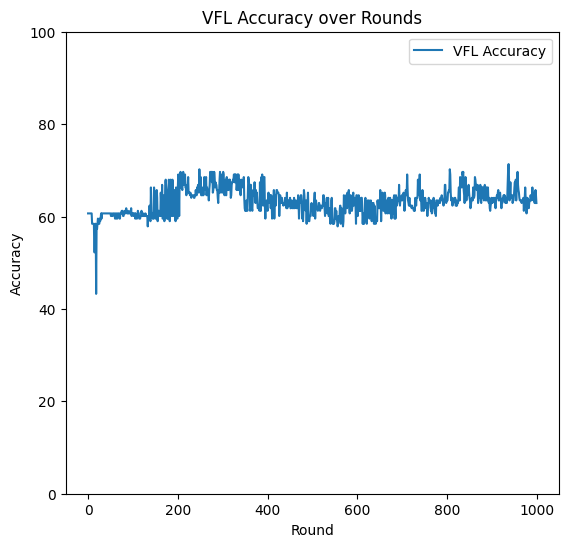

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import random



seed = 55
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def load_titanic_data():
    def _bin_age(age_series):
        bins = [-np.inf, 10, 40, np.inf]
        labels = ["Child", "Adult", "Elderly"]
        return pd.cut(age_series, bins=bins, labels=labels, right=True).astype(str).replace("nan", "Unknown")

    def _extract_title(name_series):
        titles = name_series.str.extract(" ([A-Za-z]+)\.", expand=False)
        rare_titles = {
            "Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"
        }
        titles = titles.replace(list(rare_titles), "Rare")
        titles = titles.replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
        return titles

    def _create_features(df):
        df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
        df["Age"] = _bin_age(df["Age"])
        df["Cabin"] = df["Cabin"].str[0].fillna("Unknown")
        df["Title"] = _extract_title(df["Name"])
        df.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
        return df

    def vertical_partition_rotating(df, num_participants):
        partitions = [[] for _ in range(num_participants)]
        num_features = df.shape[1]

        # Now Round-Robin Vertical distribution of features before one-hot encoding
        for i, feature in enumerate(df.columns):
            participant = i % num_participants
            partitions[participant].append(feature)

        # Raw features distribution
        for i, partition in enumerate(partitions):
            print(f"Client {i + 1} Raw Features: {partition}")

        # One-hot encoding each partition independently
        partitioned_dfs = [pd.get_dummies(df[features]) for features in partitions]

        # Final feature set for each client after one-hot encoding
        for i, partition in enumerate(partitioned_dfs):
            print(f"Client {i + 1} Final Features after One-Hot Encoding: {partition.columns.tolist()}")

        return partitioned_dfs

    def get_partitions_and_label():
        df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
        processed_df = df.dropna(subset=["Embarked", "Fare"]).copy()
        processed_df = _create_features(processed_df)
        labels = processed_df["Survived"].values

        # Train and test data split
        train_df, test_df, y_train, y_test = train_test_split(processed_df, labels, test_size=0.2, random_state=42)

        # Vertical_partitioning_rotating function
        train_partitions = vertical_partition_rotating(train_df.drop(columns=["Survived"]), 3)
        test_partitions = vertical_partition_rotating(test_df.drop(columns=["Survived"]), 3)

        # Ensuring each participant has access to labels
        for i in range(len(train_partitions)):
            train_partitions[i]['Survived'] = y_train

        for i in range(len(test_partitions)):
            test_partitions[i]['Survived'] = y_test

        return train_partitions, test_partitions, y_train, y_test

    # Partitions and Labels
    train_partitions, test_partitions, y_train, y_test = get_partitions_and_label()

    # Partitions to PyTorch datasets conversions
    def create_tensor_datasets(partitions):
        tensor_partitions = []
        for partition in partitions:
            partition = partition.apply(pd.to_numeric, errors='coerce')
            partition = partition.fillna(0)

            for col in partition.select_dtypes(include=['bool']).columns:
                partition[col] = partition[col].astype(int)

            features = partition.drop(columns=["Survived"]).values
            labels = partition["Survived"].values.astype(np.int64)

            tensor_partition = TensorDataset(torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.long))
            tensor_partitions.append(tensor_partition)
        return tensor_partitions

    train_tensor_partitions = create_tensor_datasets(train_partitions)
    test_tensor_partitions = create_tensor_datasets(test_partitions)

    return train_tensor_partitions, test_tensor_partitions, train_partitions, y_train, y_test




# Global Model definition like before
class GlobalModel(nn.Module):
    def __init__(self, input_sizes, hidden_sizes, output_size):
        super(GlobalModel, self).__init__()
        self.segments = nn.ModuleList()
        for input_size, hidden_size in zip(input_sizes, hidden_sizes):
            layers = [nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, output_size)]
            self.segments.append(nn.Sequential(*layers))

    def forward(self, x, active_segments):
        segment_outputs = []
        start_index = 0
        for i, segment in enumerate(self.segments):
            end_index = start_index + input_sizes[i]
            if i in active_segments:
                segment_input = x[:, start_index:end_index]  # We extract the segment of the input corresponding to the active participant's features only
                segment_output = segment(segment_input)
                segment_outputs.append(segment_output)
            else:
                segment_outputs.append(torch.zeros(x.size(0), output_size, device=x.device)) # Non-active segments are appended with zero
            start_index = end_index
        combined_output = torch.mean(torch.stack(segment_outputs), dim=0)
        return combined_output

# Dataset
train_tensor_partitions, test_tensor_partitions, feature_partitions, y_train, y_test = load_titanic_data()

# Input sizes after one-hot encoding
input_sizes = [partition.shape[1] - 1 for partition in feature_partitions]  # minus 1 for 'Survived' column
print("Input sizes:", input_sizes)
hidden_sizes = [10] * 3
output_size = 2 # survive or dead?

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = [GlobalModel(input_sizes, hidden_sizes, output_size).to(device) for _ in range(3)]
optimizers = [optim.Adam(model.parameters(), lr=0.01) for model in models]

# Class weights due to imbalance class distribution
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)



# Training function
def train(model, device, train_loader, optimizer, epoch, input_sizes, participant_id):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        # Zero-padding non-responsible features
        padded_data = torch.zeros(data.size(0), sum(input_sizes)).to(device)
        start_index = sum(input_sizes[:participant_id])
        end_index = start_index + input_sizes[participant_id]
        padded_data[:, start_index:end_index] = data
        optimizer.zero_grad()
        output = model(padded_data, active_segments=[participant_id])
        loss = nn.CrossEntropyLoss(weight=class_weights)(output, target)
        loss.backward()
        optimizer.step()
        #if batch_idx % 10 == 0:
            #print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')



# Selective gradient exchange function
def selective_exchange_gradients(models, input_sizes, hidden_sizes):
    num_models = len(models)
    param_indices = [0]
    cumulative_index = 0
    for i in range(len(hidden_sizes)):
        cumulative_index += (input_sizes[i] * hidden_sizes[i]) + hidden_sizes[i]
        param_indices.append(cumulative_index)

    for seg in range(len(hidden_sizes)):
        start = param_indices[seg]
        end = param_indices[seg + 1]
        for param_idx in range(start, end):
            grads = []
            for model in models:
                model_params = list(model.parameters())
                if param_idx < len(model_params) and model_params[param_idx].grad is not None:
                    grads.append(model_params[param_idx].grad)
            if grads:
                avg_grad = torch.stack(grads).mean(dim=0)
                for model in models:
                    model_params = list(model.parameters())
                    if param_idx < len(model_params):
                        model_params[param_idx].grad = avg_grad.clone()

# Model Training
federated_rounds = 1000  # To match with their setup
epochs_per_round = 1




# Lists to store accuracy after each round
vfl_accuracies = []

def evaluate(models, device, test_loaders):
    with torch.no_grad():
        test_loss = 0
        correct = 0
        all_preds = []
        all_targets = []

        for batch_data in zip(*test_loaders):
            data_list = []
            target_list = []
            for participant_id, (data, target) in enumerate(batch_data):
                data_list.append(data)
                target_list.append(target)

            target = target_list[0].to(device)
            for t in target_list:
                assert torch.equal(t, target), "Targets are not consistent across participants"

            data_combined = torch.cat(data_list, dim=1).to(device)


            #print("data_combined size:", data_combined.size())
            padded_data = torch.zeros(data_combined.size(0), sum(input_sizes)).to(device)
            #print("padded_data size before padding:", padded_data.size())

            start_index = 0
            for participant_id in range(len(input_sizes)):
                end_index = start_index + input_sizes[participant_id]
                if end_index <= data_combined.size(1):
                    #print(f"Padded data: start_index={start_index}, end_index={end_index}, data_combined[:, {start_index}:{end_index}].size()={data_combined[:, start_index:end_index].size()}")
                    padded_data[:, start_index:end_index] = data_combined[:, start_index:end_index]
                else:

                    adjusted_end_index = data_combined.size(1)
                    #print(f"Padded data: start_index={start_index}, adjusted_end_index={adjusted_end_index}, data_combined[:, {start_index}:{adjusted_end_index}].size()={data_combined[:, start_index:adjusted_end_index].size()}")
                    padded_data[:, start_index:adjusted_end_index] = data_combined[:, start_index:adjusted_end_index]
                start_index = end_index

            #print("padded_data size after padding:", padded_data.size())

            outputs = torch.zeros(data_combined.size(0), 2, device=device)
            for model in models:
                output = model(padded_data, active_segments=list(range(len(model.segments))))
                outputs += output
            outputs /= len(models)
            test_loss += nn.CrossEntropyLoss(reduction='sum')(outputs, target).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

        test_loss /= len(test_loaders[0].dataset)
        accuracy = 100. * correct / len(test_loaders[0].dataset)
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loaders[0].dataset)} ({accuracy:.0f}%)')

        return accuracy

# Rest of the code remains the same as previous scenario


for federated_round in range(federated_rounds):
    print(f"Federated Round {federated_round + 1}/{federated_rounds}")
    for participant_id in range(3):
        #print(f"  Training Participant {participant_id + 1}")
        train_loader = DataLoader(train_tensor_partitions[participant_id], batch_size=64, shuffle=True)
        for epoch in range(1, epochs_per_round + 1):
            train(models[participant_id], device, train_loader, optimizers[participant_id], epoch, input_sizes, participant_id)

    selective_exchange_gradients(models, input_sizes, hidden_sizes)

    # Accuracy after each round
    test_loaders = [DataLoader(test_tensor_partitions[i], batch_size=32, shuffle=False) for i in range(3)]
    accuracy = evaluate(models, device, test_loaders)
    vfl_accuracies.append(accuracy)

# Plotting
plt.figure(figsize=(14, 6))

# VFL Plot
plt.subplot(1, 2, 1)
plt.plot(range(federated_rounds), vfl_accuracies, label='VFL Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('VFL Accuracy over Rounds')
plt.ylim([0, 100])
plt.legend()
